In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Check GPU availability
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 0


In [9]:
BASE_DIR = "data"   # adjust if needed
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 20

train_dir = os.path.join(BASE_DIR, "train")
val_dir   = os.path.join(BASE_DIR, "val")
test_dir  = os.path.join(BASE_DIR, "test")

In [10]:
train_gen = ImageDataGenerator(rescale=1./255,
                               rotation_range=20,
                               horizontal_flip=True,
                               zoom_range=0.2)

val_test_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary')

val_data = val_test_gen.flow_from_directory(
    val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary')

test_data = val_test_gen.flow_from_directory(
    test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary', shuffle=False)

class_indices = train_data.class_indices
print("Class mapping:", class_indices)

Found 70 images belonging to 2 classes.
Found 15 images belonging to 2 classes.
Found 15 images belonging to 2 classes.
Class mapping: {'bottle': 0, 'cup': 1}


In [11]:
# 4. Build Model
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')   # binary output
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


C:\Users\Ken\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint("../saved_models/best_model.h5",
                                       save_best_only=True)
]

In [14]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    callbacks=callbacks
)

C:\Users\Ken\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6700 - loss: 0.7238

3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 5s/step - accuracy: 0.6454 - loss: 0.7331 - val_accuracy: 0.8000 - val_loss: 0.6204
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5318 - loss: 0.6997

3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step - accuracy: 0.5346 - loss: 0.6961 - val_accuracy: 0.8000 - val_loss: 0.5002
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5461 - loss: 0.7235

3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - accuracy: 0.5560 - loss: 0.7130 - val_accuracy: 0.8000 - val_loss: 0.4634
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.6203 - loss: 0.6714 - val_accuracy: 0.8000 - val_loss: 0.5508
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.6339 - loss: 0.6498 - val_accuracy: 0.7333 - val_loss: 0.6756
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - accuracy: 0.7094 - loss: 0.6382 - val_accuracy: 0.7333 - val_loss: 0.5903


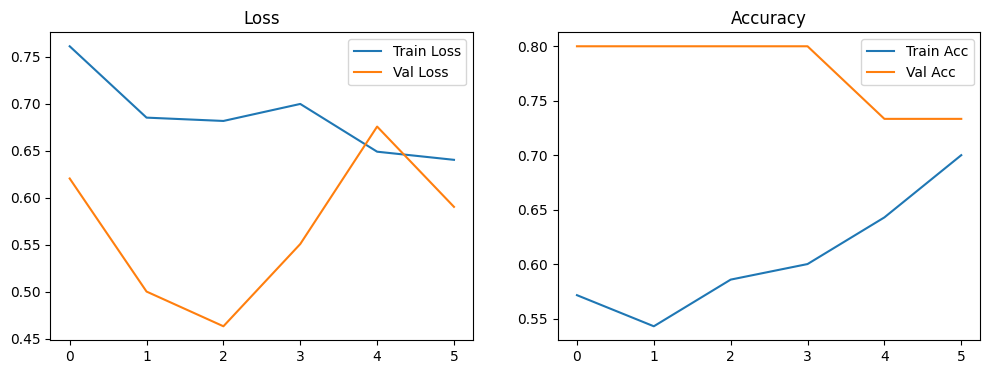

In [17]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.legend(); plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.legend(); plt.title("Accuracy")
plt.savefig("Accuracy Loss.png", dpi=300)
plt.show();


In [18]:
test_loss, test_acc = model.evaluate(test_data)
print(f"✅ Test Accuracy: {test_acc:.2%}")

C:\Users\Ken\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9333 - loss: 0.3790
✅ Test Accuracy: 93.33%
